In [ ]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
from tqdm import tqdm


# MNIST Classification problem

This is a notebook to perform the MNIST Classification Problem by using a Convolutional Neural Network. The scope of the problem is to classify properly handwritten numbers. We have 60000 numbers on our Training set, 10000 numbers on our test set. 

We also have 10 classes, whose are the numbers from 0 to 9. 

## PyTorch Implementation:

For achieving this task, we will use this notebook to learn how to use the different implementations of PyTorch. We will need installed PyTorch, some parts of the PyTorch Ecosystem, and torchsummary. Also, we will need to install Scikit-Learn for showing the Confusion Matrix. 

Our first task is to load the Data. 

<b>REMEMBER ALWAYS TO HAVE YOUR GPU WORKING</b>

### Links to the Documentation:

- <a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST">Here</a> the user will be able to find how to use the MNIST object from PyTorch. The user could also download the data directly from <a href="http://yann.lecun.com/exdb/mnist/index.html">Yann LeCun's repository.</a>

- For accessing the documentation for the random splitter, the user can refer to <a href="https://pytorch.org/docs/stable/data.html#"> documentation.</a> Note that the documentation is for the data library from PyTorch, which has inside the random splitter. 

- For accessing to the DataLoader documentation, you can follow   <a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader"> this link.</a>

### Loading the Data:

In [ ]:
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=True,
    transform=transform,
    download=True
)
mnist_test_dataset = datasets.MNIST(
    root=image_path,
    train=False,
    transform=transform,
    download=False
)
# Train/ Validation Split (I am using the splitter from PyTorch.)
mnist_train_dataset, mnist_val_dataset = random_split(mnist_dataset, [50000, 10000])

# Call DataLoaders:
train_dl = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)

val_dl = DataLoader(mnist_val_dataset, batch_size=64, shuffle=True)

# As I'm not using the test set sequentially, I won't put test set in a DataLoader.

## Creating a Model with PyTorch:

For this problem, I am using the <a href="https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html"> nn.Sequential() class</a> to create a model. Also, I am inheriting all the methods from the <a href="https://pytorch.org/docs/stable/generated/torch.nn.Module.html"> nn.Module() object</a>. 

Note that I will also train my model by parallelizing computations with a GPU. This is done by calling model().to(device).

Finally, note that as an output for the following cell, we can see a summary of the model, similar to the summary provided by Keras.

In [ ]:
# Model creation WITHOUT DROPOUT LAYER!
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels= 64, out_channels=128, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 10)
        )
    
    def forward(self, input):
        return self.main(input)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = model().to(device)

# Summary:
summary(model.main, input_size=(1,28, 28), batch_size=64)
# Selection of Loss and Optimizer:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 32, 26, 26]             320
              ReLU-2           [64, 32, 26, 26]               0
         MaxPool2d-3           [64, 32, 13, 13]               0
            Conv2d-4           [64, 64, 11, 11]          18,496
              ReLU-5           [64, 64, 11, 11]               0
         MaxPool2d-6             [64, 64, 5, 5]               0
            Conv2d-7            [64, 128, 3, 3]          73,856
              ReLU-8            [64, 128, 3, 3]               0
         MaxPool2d-9            [64, 128, 1, 1]               0
          Flatten-10                  [64, 128]               0
           Linear-11                  [64, 128]          16,512
             ReLU-12                  [64, 128]               0
          Dropout-13                  [64, 128]               0
           Linear-14                  [

## Training of the Model

More than trying to achieve the highest possible score, on this notebook we are aiming to regularize the model by adding dropout layers and performing EarlyStopping during the training of the network. 

Each part of the training function is commented to aid the easy reading of the code.

In [ ]:
# Training Script for Classification tasks, with EarlyStopping:


def train(model, train_dl, num_epochs=100, patience=5):

    # Lists for storing the training values:
    training_loss = []
    training_acc = []
    val_loss = []
    val_acc = []
    # Control for the Early Stopping:
    best_acc = 0
    counter = 0

    for epoch in range(num_epochs):
        # Initialize the running loss and accuracy for estimating the metrics 
        # during the running of each batch. 
        running_loss = 0
        running_acc = 0

        for x_batch, y_batch in tqdm(train_dl):
            # Prediciton:
            pred = model(x_batch.to(device))
            # Computing the Loss:
            loss = loss_fn(pred, y_batch.to(device))
            # We want to get an estimate of the loss per epoch
            running_loss += loss.item()/len(train_dl)
            # Backpropagation of the loss:
            loss.backward()
            # Actualization of the weights:
            optimizer.step()
            # Setting to zero the grads.
            optimizer.zero_grad()
            # Computing running accuracy.
            correct = (torch.argmax(pred, dim=1) == y_batch.to(device)).float()
            running_acc += correct.sum()/len(train_dl.dataset)
        # History of the loss and accuracy per Epoch:
        training_loss.append(running_loss)
        training_acc.append(running_acc.cpu())
        print(
            f'Epoch {epoch+1} / {num_epochs}. Training Loss = {running_loss: .4f} '
            f'Training_acc = {running_acc : .4f}')

        # Doing the same for the validation.
        # (Difference: We don't compute the gradients)

        running_loss = 0
        running_acc = 0
        for x_batch, y_batch in val_dl:
            pred = model(x_batch.to(device))
            loss = loss_fn(pred, y_batch.to(device))
            running_loss += loss.item()/len(train_dl)
            correct = (torch.argmax(pred, dim=1) == y_batch.to(device)).float()
            running_acc += correct.sum()/len(val_dl.dataset)
        val_loss.append(running_loss)
        val_acc.append(running_acc.cpu())
        print(
            f'Val_Loss = {running_loss: .4f} '
            f'Val_acc = {running_acc : .4f}')
        
        # Early Stopping Criteria, note that if the accuracy is not improving
        # after several epochs (given by the patience), it will stop and save
        # the model that is giving best results on unseen data. 
        
        if float(running_acc) < float(best_acc):
            counter +=1
            if counter > patience:
                print('Early stopping achieved.')
                model=snapshot
                return training_loss, training_acc, val_loss, val_acc
        else:
            counter = 0
            best_acc = running_acc
            snapshot = model
            
        print(f'Best val_acc = {best_acc}')        
        print(f'counter is {counter}')
        
    return training_loss, training_acc, val_loss, val_acc


hist = train(model, num_epochs=100, patience=10, train_dl=train_dl)

100%|██████████| 782/782 [00:15<00:00, 51.26it/s]


Epoch 1 / 100. Training Loss =  0.6271 Training_acc =  0.7911
Val_Loss =  0.0401 Val_acc =  0.9485
Best val_acc = 0.9484997987747192
counter is 0


100%|██████████| 782/782 [00:07<00:00, 97.85it/s] 


Epoch 2 / 100. Training Loss =  0.1562 Training_acc =  0.9599
Val_Loss =  0.0237 Val_acc =  0.9694
Best val_acc = 0.9693995714187622
counter is 0


100%|██████████| 782/782 [00:07<00:00, 99.97it/s] 


Epoch 3 / 100. Training Loss =  0.1081 Training_acc =  0.9722
Val_Loss =  0.0199 Val_acc =  0.9752
Best val_acc = 0.9751991033554077
counter is 0


100%|██████████| 782/782 [00:07<00:00, 100.82it/s]


Epoch 4 / 100. Training Loss =  0.0874 Training_acc =  0.9778
Val_Loss =  0.0162 Val_acc =  0.9800
Best val_acc = 0.9799994826316833
counter is 0


100%|██████████| 782/782 [00:07<00:00, 100.15it/s]


Epoch 5 / 100. Training Loss =  0.0729 Training_acc =  0.9812
Val_Loss =  0.0163 Val_acc =  0.9798
Best val_acc = 0.9799994826316833
counter is 1


100%|██████████| 782/782 [00:07<00:00, 101.78it/s]


Epoch 6 / 100. Training Loss =  0.0628 Training_acc =  0.9840
Val_Loss =  0.0220 Val_acc =  0.9751
Best val_acc = 0.9799994826316833
counter is 2


100%|██████████| 782/782 [00:08<00:00, 94.16it/s] 


Epoch 7 / 100. Training Loss =  0.0565 Training_acc =  0.9856
Val_Loss =  0.0145 Val_acc =  0.9822
Best val_acc = 0.9821990728378296
counter is 0


100%|██████████| 782/782 [00:07<00:00, 101.29it/s]


Epoch 8 / 100. Training Loss =  0.0511 Training_acc =  0.9872
Val_Loss =  0.0157 Val_acc =  0.9824
Best val_acc = 0.9823989272117615
counter is 0


100%|██████████| 782/782 [00:07<00:00, 98.86it/s]


Epoch 9 / 100. Training Loss =  0.0459 Training_acc =  0.9886
Val_Loss =  0.0132 Val_acc =  0.9847
Best val_acc = 0.9846988916397095
counter is 0


100%|██████████| 782/782 [00:08<00:00, 92.14it/s] 


Epoch 10 / 100. Training Loss =  0.0395 Training_acc =  0.9903
Val_Loss =  0.0139 Val_acc =  0.9833
Best val_acc = 0.9846988916397095
counter is 1


100%|██████████| 782/782 [00:07<00:00, 101.49it/s]


Epoch 11 / 100. Training Loss =  0.0389 Training_acc =  0.9904
Val_Loss =  0.0180 Val_acc =  0.9816
Best val_acc = 0.9846988916397095
counter is 2


100%|██████████| 782/782 [00:11<00:00, 69.84it/s] 


Epoch 12 / 100. Training Loss =  0.0349 Training_acc =  0.9914
Val_Loss =  0.0138 Val_acc =  0.9854
Best val_acc = 0.9853990077972412
counter is 0


100%|██████████| 782/782 [00:07<00:00, 101.91it/s]


Epoch 13 / 100. Training Loss =  0.0306 Training_acc =  0.9928
Val_Loss =  0.0168 Val_acc =  0.9810
Best val_acc = 0.9853990077972412
counter is 1


100%|██████████| 782/782 [00:07<00:00, 100.99it/s]


Epoch 14 / 100. Training Loss =  0.0266 Training_acc =  0.9931
Val_Loss =  0.0235 Val_acc =  0.9791
Best val_acc = 0.9853990077972412
counter is 2


100%|██████████| 782/782 [00:07<00:00, 101.23it/s]


Epoch 15 / 100. Training Loss =  0.0291 Training_acc =  0.9928
Val_Loss =  0.0194 Val_acc =  0.9797
Best val_acc = 0.9853990077972412
counter is 3


100%|██████████| 782/782 [00:07<00:00, 100.79it/s]


Epoch 16 / 100. Training Loss =  0.0289 Training_acc =  0.9929
Val_Loss =  0.0134 Val_acc =  0.9854
Best val_acc = 0.9853990077972412
counter is 4


100%|██████████| 782/782 [00:07<00:00, 102.81it/s]


Epoch 17 / 100. Training Loss =  0.0232 Training_acc =  0.9944
Val_Loss =  0.0152 Val_acc =  0.9852
Best val_acc = 0.9853990077972412
counter is 5


100%|██████████| 782/782 [00:08<00:00, 89.60it/s]


Epoch 18 / 100. Training Loss =  0.0231 Training_acc =  0.9941
Val_Loss =  0.0146 Val_acc =  0.9875
Best val_acc = 0.9874988794326782
counter is 0


100%|██████████| 782/782 [00:07<00:00, 101.10it/s]


Epoch 19 / 100. Training Loss =  0.0197 Training_acc =  0.9949
Val_Loss =  0.0144 Val_acc =  0.9855
Best val_acc = 0.9874988794326782
counter is 1


100%|██████████| 782/782 [00:07<00:00, 102.44it/s]


Epoch 20 / 100. Training Loss =  0.0216 Training_acc =  0.9946
Val_Loss =  0.0139 Val_acc =  0.9872
Best val_acc = 0.9874988794326782
counter is 2


100%|██████████| 782/782 [00:07<00:00, 100.49it/s]


Epoch 21 / 100. Training Loss =  0.0230 Training_acc =  0.9945
Val_Loss =  0.0158 Val_acc =  0.9867
Best val_acc = 0.9874988794326782
counter is 3


100%|██████████| 782/782 [00:07<00:00, 100.53it/s]


Epoch 22 / 100. Training Loss =  0.0191 Training_acc =  0.9955
Val_Loss =  0.0149 Val_acc =  0.9867
Best val_acc = 0.9874988794326782
counter is 4


100%|██████████| 782/782 [00:07<00:00, 101.43it/s]


Epoch 23 / 100. Training Loss =  0.0179 Training_acc =  0.9952
Val_Loss =  0.0157 Val_acc =  0.9862
Best val_acc = 0.9874988794326782
counter is 5


100%|██████████| 782/782 [00:08<00:00, 94.63it/s]


Epoch 24 / 100. Training Loss =  0.0162 Training_acc =  0.9960
Val_Loss =  0.0176 Val_acc =  0.9849
Best val_acc = 0.9874988794326782
counter is 6


100%|██████████| 782/782 [00:07<00:00, 102.21it/s]


Epoch 25 / 100. Training Loss =  0.0187 Training_acc =  0.9953
Val_Loss =  0.0141 Val_acc =  0.9875
Best val_acc = 0.9874988794326782
counter is 0


100%|██████████| 782/782 [00:07<00:00, 102.99it/s]


Epoch 26 / 100. Training Loss =  0.0165 Training_acc =  0.9964
Val_Loss =  0.0206 Val_acc =  0.9866
Best val_acc = 0.9874988794326782
counter is 1


100%|██████████| 782/782 [00:08<00:00, 96.09it/s] 


Epoch 27 / 100. Training Loss =  0.0169 Training_acc =  0.9964
Val_Loss =  0.0165 Val_acc =  0.9866
Best val_acc = 0.9874988794326782
counter is 2


100%|██████████| 782/782 [00:07<00:00, 101.96it/s]


Epoch 28 / 100. Training Loss =  0.0164 Training_acc =  0.9959
Val_Loss =  0.0177 Val_acc =  0.9854
Best val_acc = 0.9874988794326782
counter is 3


100%|██████████| 782/782 [00:07<00:00, 100.80it/s]


Epoch 29 / 100. Training Loss =  0.0163 Training_acc =  0.9958
Val_Loss =  0.0204 Val_acc =  0.9869
Best val_acc = 0.9874988794326782
counter is 4


100%|██████████| 782/782 [00:07<00:00, 101.87it/s]


Epoch 30 / 100. Training Loss =  0.0137 Training_acc =  0.9965
Val_Loss =  0.0202 Val_acc =  0.9851
Best val_acc = 0.9874988794326782
counter is 5


100%|██████████| 782/782 [00:07<00:00, 102.08it/s]


Epoch 31 / 100. Training Loss =  0.0118 Training_acc =  0.9968
Val_Loss =  0.0201 Val_acc =  0.9880
Best val_acc = 0.9879988431930542
counter is 0


100%|██████████| 782/782 [00:07<00:00, 101.67it/s]


Epoch 32 / 100. Training Loss =  0.0159 Training_acc =  0.9967
Val_Loss =  0.0144 Val_acc =  0.9880
Best val_acc = 0.9879988431930542
counter is 1


100%|██████████| 782/782 [00:07<00:00, 101.38it/s]


Epoch 33 / 100. Training Loss =  0.0142 Training_acc =  0.9967
Val_Loss =  0.0205 Val_acc =  0.9853
Best val_acc = 0.9879988431930542
counter is 2


100%|██████████| 782/782 [00:07<00:00, 102.58it/s]


Epoch 34 / 100. Training Loss =  0.0150 Training_acc =  0.9966
Val_Loss =  0.0173 Val_acc =  0.9863
Best val_acc = 0.9879988431930542
counter is 3


100%|██████████| 782/782 [00:07<00:00, 102.15it/s]


Epoch 35 / 100. Training Loss =  0.0116 Training_acc =  0.9970
Val_Loss =  0.0199 Val_acc =  0.9874
Best val_acc = 0.9879988431930542
counter is 4


100%|██████████| 782/782 [00:07<00:00, 101.42it/s]


Epoch 36 / 100. Training Loss =  0.0106 Training_acc =  0.9977
Val_Loss =  0.0146 Val_acc =  0.9862
Best val_acc = 0.9879988431930542
counter is 5


100%|██████████| 782/782 [00:07<00:00, 101.22it/s]


Epoch 37 / 100. Training Loss =  0.0147 Training_acc =  0.9963
Val_Loss =  0.0172 Val_acc =  0.9863
Best val_acc = 0.9879988431930542
counter is 6


100%|██████████| 782/782 [00:07<00:00, 102.60it/s]


Epoch 38 / 100. Training Loss =  0.0111 Training_acc =  0.9974
Val_Loss =  0.0190 Val_acc =  0.9870
Best val_acc = 0.9879988431930542
counter is 7


100%|██████████| 782/782 [00:07<00:00, 102.43it/s]


Epoch 39 / 100. Training Loss =  0.0123 Training_acc =  0.9972
Val_Loss =  0.0185 Val_acc =  0.9891
Best val_acc = 0.9890987873077393
counter is 0


100%|██████████| 782/782 [00:07<00:00, 100.50it/s]


Epoch 40 / 100. Training Loss =  0.0139 Training_acc =  0.9969
Val_Loss =  0.0201 Val_acc =  0.9868
Best val_acc = 0.9890987873077393
counter is 1


100%|██████████| 782/782 [00:07<00:00, 101.90it/s]


Epoch 41 / 100. Training Loss =  0.0126 Training_acc =  0.9973
Val_Loss =  0.0191 Val_acc =  0.9856
Best val_acc = 0.9890987873077393
counter is 2


100%|██████████| 782/782 [00:07<00:00, 99.05it/s]


Epoch 42 / 100. Training Loss =  0.0130 Training_acc =  0.9971
Val_Loss =  0.0162 Val_acc =  0.9880
Best val_acc = 0.9890987873077393
counter is 3


100%|██████████| 782/782 [00:07<00:00, 100.92it/s]


Epoch 43 / 100. Training Loss =  0.0118 Training_acc =  0.9974
Val_Loss =  0.0258 Val_acc =  0.9852
Best val_acc = 0.9890987873077393
counter is 4


100%|██████████| 782/782 [00:07<00:00, 101.80it/s]


Epoch 44 / 100. Training Loss =  0.0110 Training_acc =  0.9974
Val_Loss =  0.0243 Val_acc =  0.9849
Best val_acc = 0.9890987873077393
counter is 5


100%|██████████| 782/782 [00:07<00:00, 102.45it/s]


Epoch 45 / 100. Training Loss =  0.0109 Training_acc =  0.9976
Val_Loss =  0.0162 Val_acc =  0.9862
Best val_acc = 0.9890987873077393
counter is 6


100%|██████████| 782/782 [00:07<00:00, 102.54it/s]


Epoch 46 / 100. Training Loss =  0.0087 Training_acc =  0.9979
Val_Loss =  0.0189 Val_acc =  0.9880
Best val_acc = 0.9890987873077393
counter is 7


100%|██████████| 782/782 [00:07<00:00, 101.37it/s]


Epoch 47 / 100. Training Loss =  0.0092 Training_acc =  0.9979
Val_Loss =  0.0362 Val_acc =  0.9759
Best val_acc = 0.9890987873077393
counter is 8


100%|██████████| 782/782 [00:07<00:00, 101.68it/s]


Epoch 48 / 100. Training Loss =  0.0101 Training_acc =  0.9978
Val_Loss =  0.0259 Val_acc =  0.9871
Best val_acc = 0.9890987873077393
counter is 9


100%|██████████| 782/782 [00:07<00:00, 101.43it/s]


Epoch 49 / 100. Training Loss =  0.0105 Training_acc =  0.9978
Val_Loss =  0.0245 Val_acc =  0.9854
Best val_acc = 0.9890987873077393
counter is 10


100%|██████████| 782/782 [00:08<00:00, 96.79it/s]


Epoch 50 / 100. Training Loss =  0.0106 Training_acc =  0.9977
Val_Loss =  0.0213 Val_acc =  0.9883
Early stopping achieved.


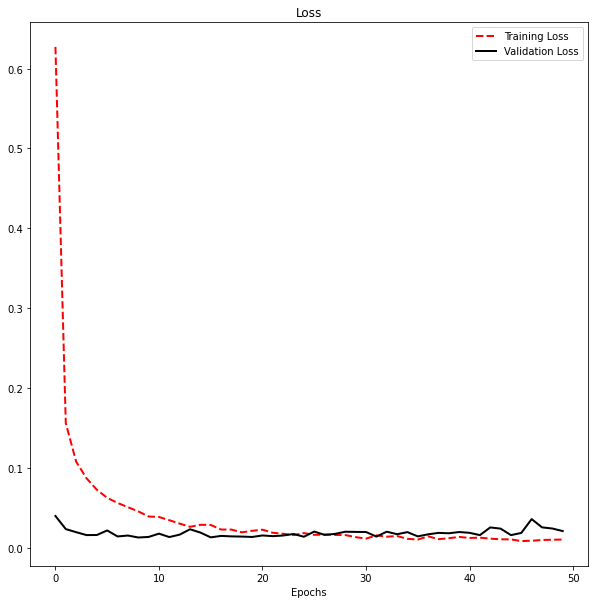

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(hist[0], 'r--',lw=2, label='Training Loss')
plt.plot(hist[2], 'k',lw=2, label='Validation Loss')
plt.legend(loc=1)
plt.title('Loss')
plt.xlabel('Epochs')
plt.show()

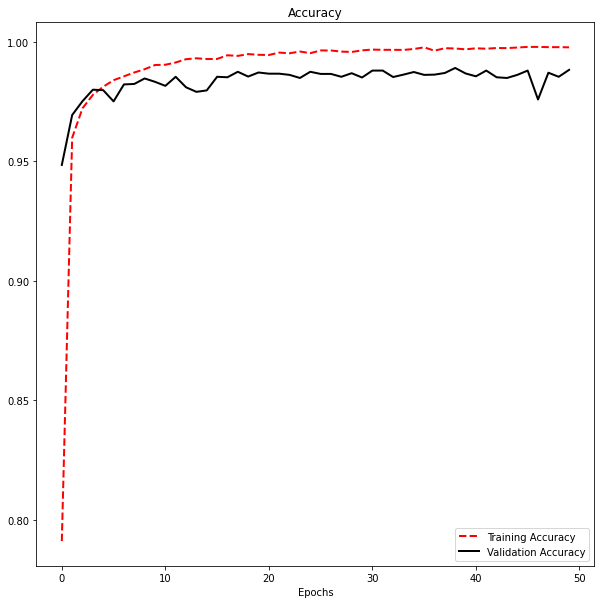

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(hist[1], 'r--',lw=2, label='Training Accuracy')
plt.plot(hist[3], 'k',lw=2, label='Validation Accuracy')
plt.legend(loc=4)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.show()

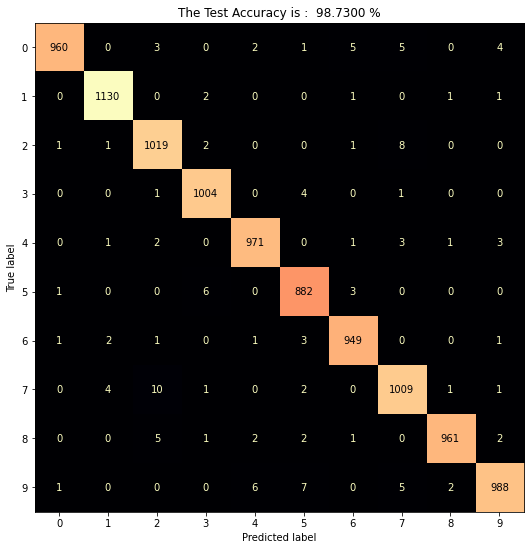

In [ ]:
model.to('cpu')
pred = torch.argmax(model((mnist_test_dataset.data.unsqueeze(1)/255)), dim=1)

correct = (pred == mnist_test_dataset.targets).float()
test_acc = correct.sum()/len(mnist_test_dataset.targets)
conf_matrix_1 = confusion_matrix(mnist_test_dataset.targets, pred)
fig, ax = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_1,)
disp.plot(ax=ax, cmap=plt.cm.magma, colorbar=False)
plt.title(f'The Test Accuracy is : {test_acc*100 : .4f} %')
plt.savefig('conf_MNIST_cnn_no_dropout.jpg', bbox_inches='tight')
plt.show()

In [ ]:
model

model(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Linear(in_features=128, out_features=128, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=128, out_features=128, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.3, inplace=False)
    (19): Linear(in_features=128, out_features=